# WDL 2021 - Final

## Authors

Ana Almeida &
Bruno Silva &
Carolina Alves &
Fábio Santos

## External links and resources

INCLUIR AQUI ...

# Introduction

# Data pre-processing

## Import libraries and customize seaborn

In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime
import pickle
#import requestsz
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#from math import floor, sin, cos, sqrt, atan2, radians, asin
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
#import folium
from itertools import combinations
#import networkx as nx
import matplotlib.dates as mdates

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

import warnings
warnings.filterwarnings('ignore')

base = 'Data/noise_data/csv_format'

## Auxiliar functions

In [2]:
# bar plot function
def bar_plot(_x, _y, _data):
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x=_x, y=_y, data=_data)
    plt.xticks(rotation=90)
    plt.draw()
    
# performs the encoding of categorical features to ordinal numbers
def encode_categorical_features(_df, features):
    df = _df.copy()
    enc = OrdinalEncoder()
    df[features] = enc.fit_transform(df[features]).astype(int)
    
    return enc, df

def correlation_matrix (df, fig_dim):
    cor = df.corr()
    mask = np.triu(np.ones_like(cor, dtype=bool))
    fig,ax = plt.subplots(figsize=fig_dim)
    sns.heatmap(cor, mask=mask, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

## Loading the dataset

In [3]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
def saving_dfs_as_binary_files(base):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(2016) + ".csv", sep=";")
    
    for year in range(2017, 2020):
        _df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, _df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base)

In [4]:
sensors = ['C1', 'C2', 'C3', 'C4', 'C5']

# Opening data
def get_sensors_data(sensors):
    df = pickle.load(open(base+'/'+"df_raw", "rb" ))

    for col in sensors:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"] + df['Ora'] , format='%d-%m-%Y%H:00')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)
    
    df = df.set_index('date')

    # get average of noise levels
    temp = ['C1_temp', 'C2_temp', 'C3_temp', 'C4_temp', 'C5_temp']
    for i in range(len(sensors)):
        df[temp[i]] = pow(10, df[sensors[i]]/10)

    df['C_avg'] = df[temp].sum(axis = 1)\
        .div(5 - df[temp].isnull().sum(axis=1))
    df['C_avg'] = 10*np.log10(df['C_avg'])
    
    #return df
    return df[['year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5', 'C_avg']]
    
df = get_sensors_data(sensors)
df

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
date,,,,,,,,,,
2016-06-01 00:00:00,2016,6,1,0,61.1,58.8,63.7,60.4,60.2,61.162532
2016-06-01 01:00:00,2016,6,1,1,57.2,56.1,60.4,57.7,58.4,58.207715
2016-06-01 02:00:00,2016,6,1,2,52.5,53.4,52.9,56.7,56.5,54.788571
2016-06-01 03:00:00,2016,6,1,3,50.6,46.6,45.7,47.9,55.6,50.951102
2016-06-01 04:00:00,2016,6,1,4,47.4,46.2,45.1,45.8,56.8,51.110268
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,12,31,19,62.2,59.8,60.3,NaN,NaN,60.894457
2019-12-31 20:00:00,2019,12,31,20,59.4,59.7,55.9,NaN,NaN,58.639695
2019-12-31 21:00:00,2019,12,31,21,59.2,61.0,56.0,NaN,NaN,59.188681


In [5]:
df.shape

(31416, 10)

## Data types, uniques, NaNs and Zeros information 

**Checking type of data, number of unique values and the presence of missing values and zeros**

In [6]:
def eda_to_df(df):
    header="+" + ("-"*112) + "+"
    form = "|{:^18s}|{:^17s}|{:^10s}|{:^10s}|{:^15s}|{:^10s}|{:^15s}|{:^10s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?", "Number of NaN" ,"%NaN", "Number of 0s" ,"%0s"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), # Column
                          str(df[col].dtypes), # Type
                          str(len(df[col].unique())), # Uniques
                          str(df[col].isnull().values.any()), # NaN?
                          str(df[col].isnull().sum()), # Number of NaNs
                          str(round(((df[col].isnull().sum())/len(df[col]))*100,5)), # %NaN
                          str((df[col] == 0).sum()), # Number of 0's
                          str(round((((df[col] == 0).sum())/len(df[col]))*100,5))) # %0's
              )
    print(header)    

eda_to_df(df)

+----------------------------------------------------------------------------------------------------------------+
|      Column      |      Type       | Uniques  |   NaN?   | Number of NaN |   %NaN   | Number of 0s  |   %0s    |
+----------------------------------------------------------------------------------------------------------------+
|       year       |      int64      |    4     |  False   |       0       |   0.0    |       0       |   0.0    |
|      month       |      int64      |    12    |  False   |       0       |   0.0    |       0       |   0.0    |
|       day        |      int64      |    31    |  False   |       0       |   0.0    |       0       |   0.0    |
|       hour       |      int64      |    24    |  False   |       0       |   0.0    |     1309      | 4.16667  |
|        C1        |     float64     |   395    |   True   |     3046      |  9.6957  |       0       |   0.0    |
|        C2        |     float64     |   362    |   True   |     2395      |  7.

ANÁLISE - ADICIONAR TEXTO

Existe bastante informação em falta nos sensores de ruído. O sensor 3 tem x% ...

## Data Statistics

### General Statistics

In [7]:
df.describe()

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
count,31416.000000,31416.000000,31416.000000,31416.000000,28370.000000,29021.000000,18433.000000,24793.000000,27494.000000,31087.000000
mean,2017.673033,6.931245,15.731856,11.500000,59.457804,58.090407,59.955498,59.422833,61.125453,60.577175
std,1.051066,3.382005,8.801526,6.922297,5.629829,5.034970,7.907549,5.063291,4.492895,5.073491
min,2016.000000,1.000000,1.000000,0.000000,32.600000,32.400000,38.500000,30.100000,33.100000,32.500000
25%,2017.000000,4.000000,8.000000,5.750000,57.600000,55.800000,55.000000,57.600000,58.900000,58.719534
50%,2018.000000,7.000000,16.000000,11.500000,60.500000,59.400000,60.400000,60.800000,62.100000,61.565931
75%,2019.000000,10.000000,23.000000,17.250000,62.500000,61.500000,64.200000,62.700000,64.100000,63.368428
max,2019.000000,12.000000,31.000000,23.000000,95.600000,80.300000,82.300000,76.800000,82.700000,88.623121


### Histogram

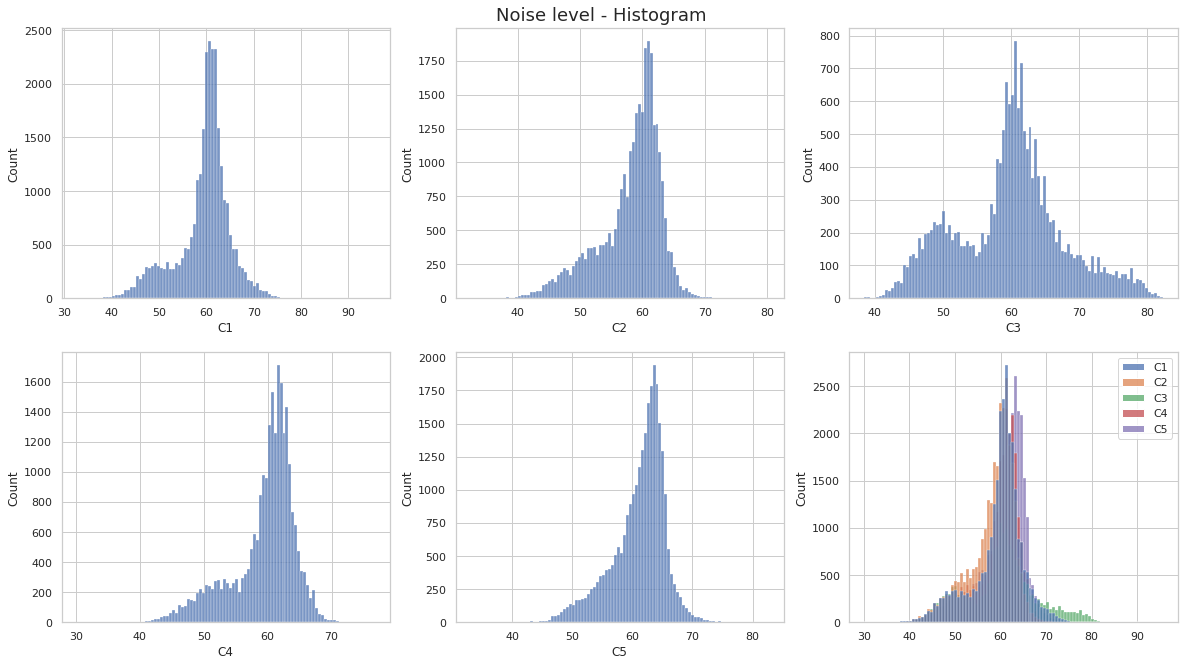

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
m = 'stack'
fd = {'fontsize': 16}
fd_l = {'fontsize': 12}

axis = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]

for i in range(6):    
    if i==5:
        sns.histplot(df[sensors], ax=axis[i],bins=100, multiple=m)
    else:
        sns.histplot(df[sensors[i]], ax=axis[i], bins=100, multiple=m)

fig.suptitle("Noise level - Histogram", size=18)
fig.subplots_adjust(top=0.95)

Os sensores apresentam distribuições semelhantes.

## Plotting Data

Text(0.5, 0.9, 'Noise Level')

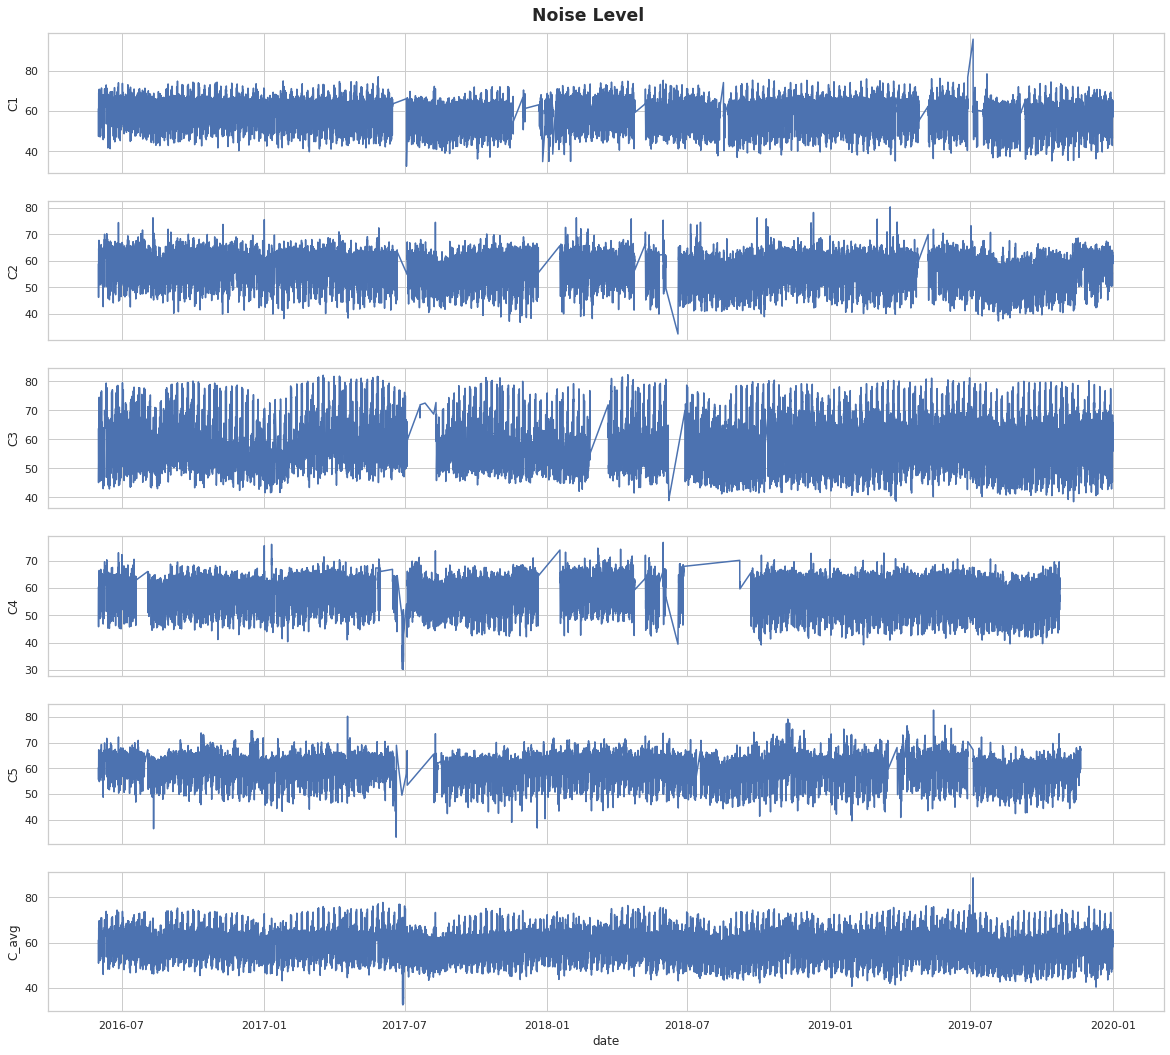

In [9]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(20, 18))
sns.lineplot(data=df.C1, ax=axs[0])
sns.lineplot(data=df.C2, ax=axs[1])
sns.lineplot(data=df.C3, ax=axs[2])
sns.lineplot(data=df.C4, ax=axs[3])
sns.lineplot(data=df.C5, ax=axs[4])
sns.lineplot(data=df.C_avg, ax=axs[5])

fig.suptitle("Noise Level", fontsize='x-large', fontweight='bold', y=.9)

In [10]:
last_date_c4 = df['C4'].dropna().tail(1).index.values
print("C4 - Last date with value: " + str(last_date_c4))
last_date_c5 = df['C5'].dropna().tail(1).index.values
print("C5 - Last date with value: " + str(last_date_c5))

C4 - Last date with value: ['2019-10-24T17:00:00.000000000']
C5 - Last date with value: ['2019-11-20T08:00:00.000000000']


O gráfico em cima permite visualizar que:
- todos os sensores têm períodos de falha (períodos largos sem valores)
- o sensor 4 e 5 deixam de ter valores antes do fim de 2019 em ... e ... respetivamente

# Exploratory Data Analysis

## Correlation between sensors

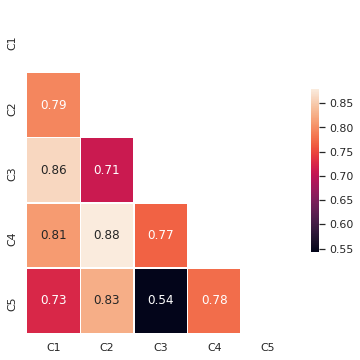

In [11]:
correlation_matrix(df[sensors], (6,6))

O sensor C1 está mais correlacionado com o sensor c3 (e vice-versa). Como podemos observar pela localização dos sensores, estes sensores estão geograficamente muito próximos, fazendo por isso sentido que os seus valores estejam altamente correlacionados.

O sensor C2 está mais correlacionado com o sensor c4 (e vice-versa). blá, blá, blá... o mesmo que o anterior

O sensor c5 encontra-se altemente correlacionado com o sensor c2 (acho que é o sensor mais próximo dele mas confirmar com o Bruno)

## Autocorrelation Plot

A autocorrelação compara a série temporal com ela mesma (em intantes temporais diferentes) de forma a encontrar as lags que estão mais correlacionadas entre si. citar: https://otexts.com/fpp2/autocorrelation.html

Note-se que a forma como é feita a comparação das lags é através do shift da série temporal. À medida que o tempo passa vamos ter menos valores para compara e por isso é esperado o valor da correlação diminuir ao longo do tempo.

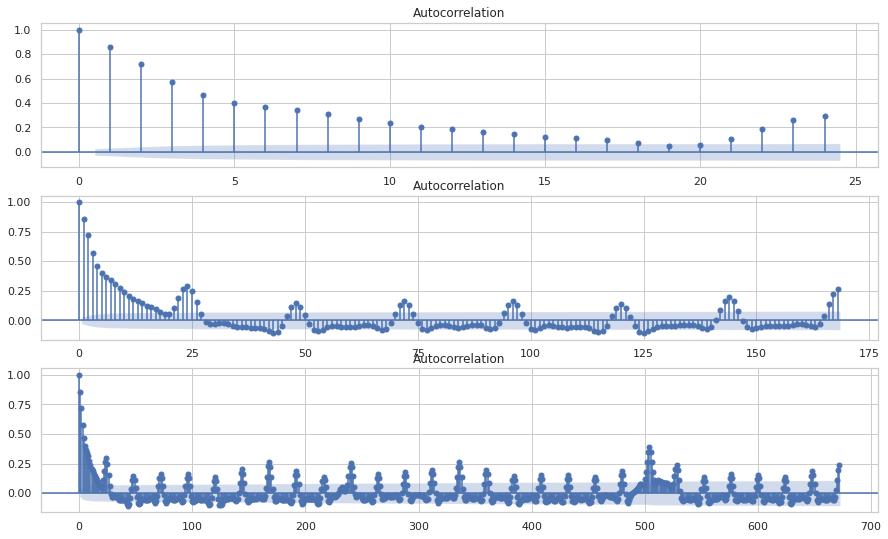

In [12]:
def autocorrelation(df, ps):
    
    df = df.fillna(0)
    
    fig, ax = plt.subplots(len(ps), 1, figsize=(15, 3*len(ps)))
    for i in range(len(ps)):
        plot_acf(df.tolist(), lags=ps[i], ax=ax[i])
        
autocorrelation(df[(df.year==2016)].C1, [24, 24*7, 24*7*4])

Pelo que podemos ver no gráfico acima:
- no primeiro plot temos as 24 primeiras lags (1 dia). O valor da autocorrelação desce e depois começa a aumentar atingindo o máximo nas 24h
- no segundo plot vemos que este padrão volta a repetir-se e temos os máximos nos multiplos de 24 (ao fim de um dia, dois dias...)
- no 3º gráfico vemos que mais uma vez este padrão se repete ao longo do mês sendo possível observar picos mais altos correspondentes às lags de cada semana

                                                24*7 = 168
                                                24*14 = 336
                                                24*21 = 504

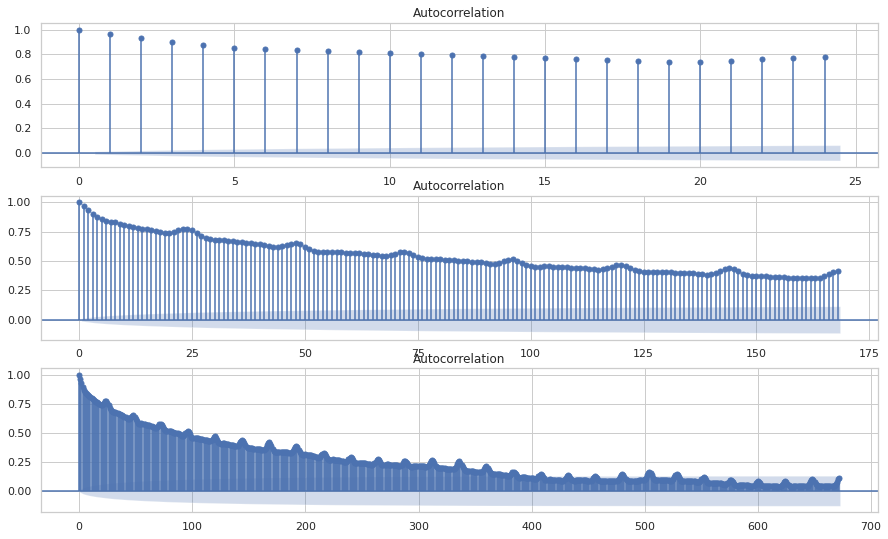

In [13]:
autocorrelation(df.C1, [24, 24*7, 24*7*4])

Neste ano consideramos de 2016 a 2019 e por isso, apesar de os mesmos padrões se observarem, estes não se destinguem tanto porque temos muitos mais dados para comparar

## Seasonal decompose

Additive decomposition since our data has 0's.

Faz-se a dec. aditiva apenas porque a multiplicativa não se aplica a este  caso porque temops zeros.

A decomposição divide os dados em 3 componentes: Trend + Seasonal + Resid

Se visualizarmos padrões sazonais podemos aplicar métodos que tenham em conta padrões sazonais


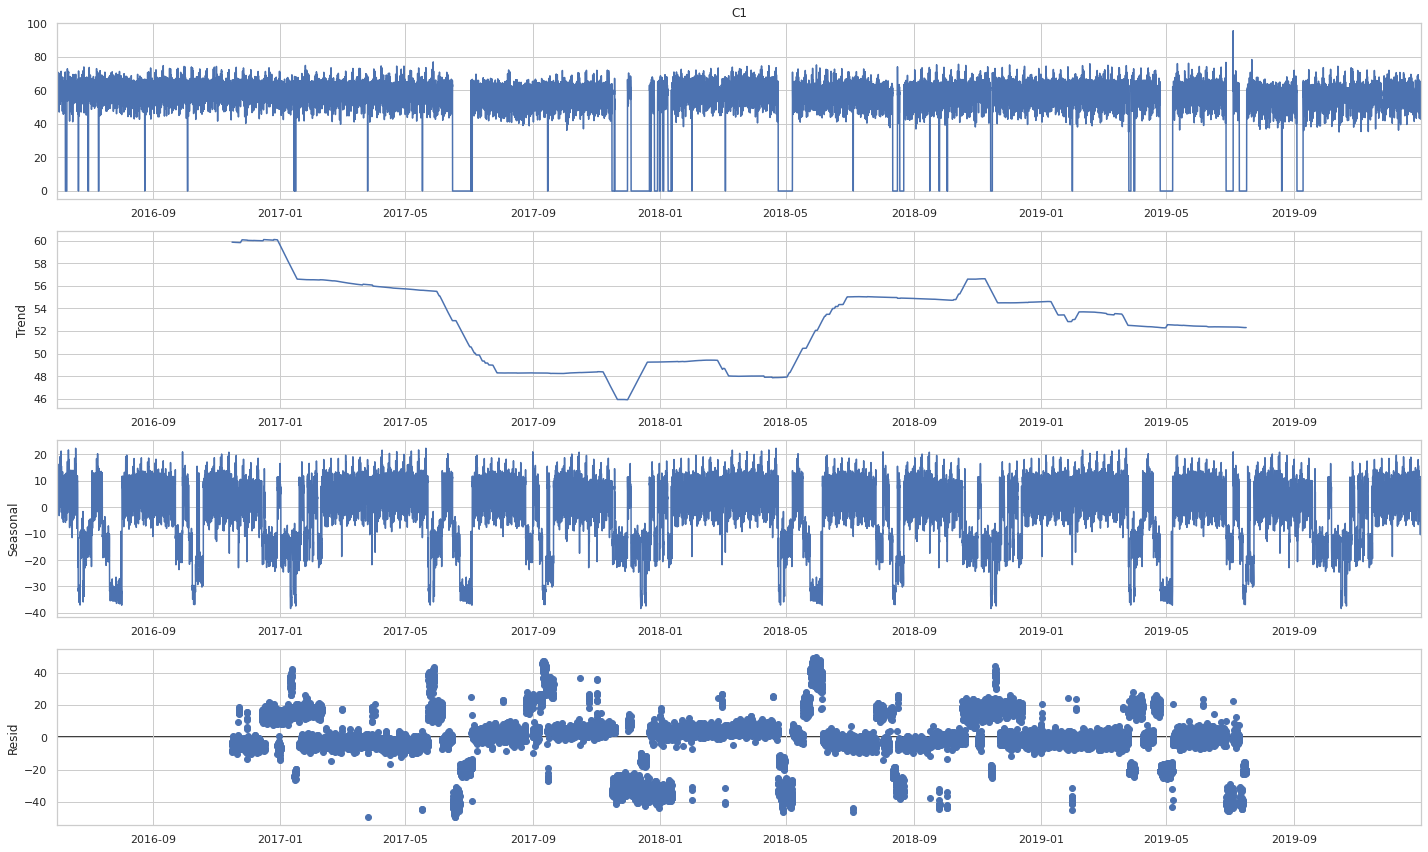

In [14]:
def ts_seasonal_decompose(df, ps):
    
    df = df.fillna(0)

    for p in ps:
        decomposition = seasonal_decompose(df, model='additive', period=p)
        decomposition.plot()
        
ts_seasonal_decompose(df.C1, [24*7*4*12]) # 24*7*4*12 -> vai considerar os padrões anuais dos dados

Ao analisarmos os dados todos para o sensor 1 conseguimos visualizar a existencia de padrões sasonais (diários, semanis, mensais e anuais) capturados pela trend component. 

A trend diminui e depois volta a aumentar, no entanto isto pode dever-se ao facto de terem aumentado as falhas do sensor.

***Considerar métodos de smoothing ou interpolação???***

Se nos focarmos apenas num ano de dados, obtemos o seguinte:

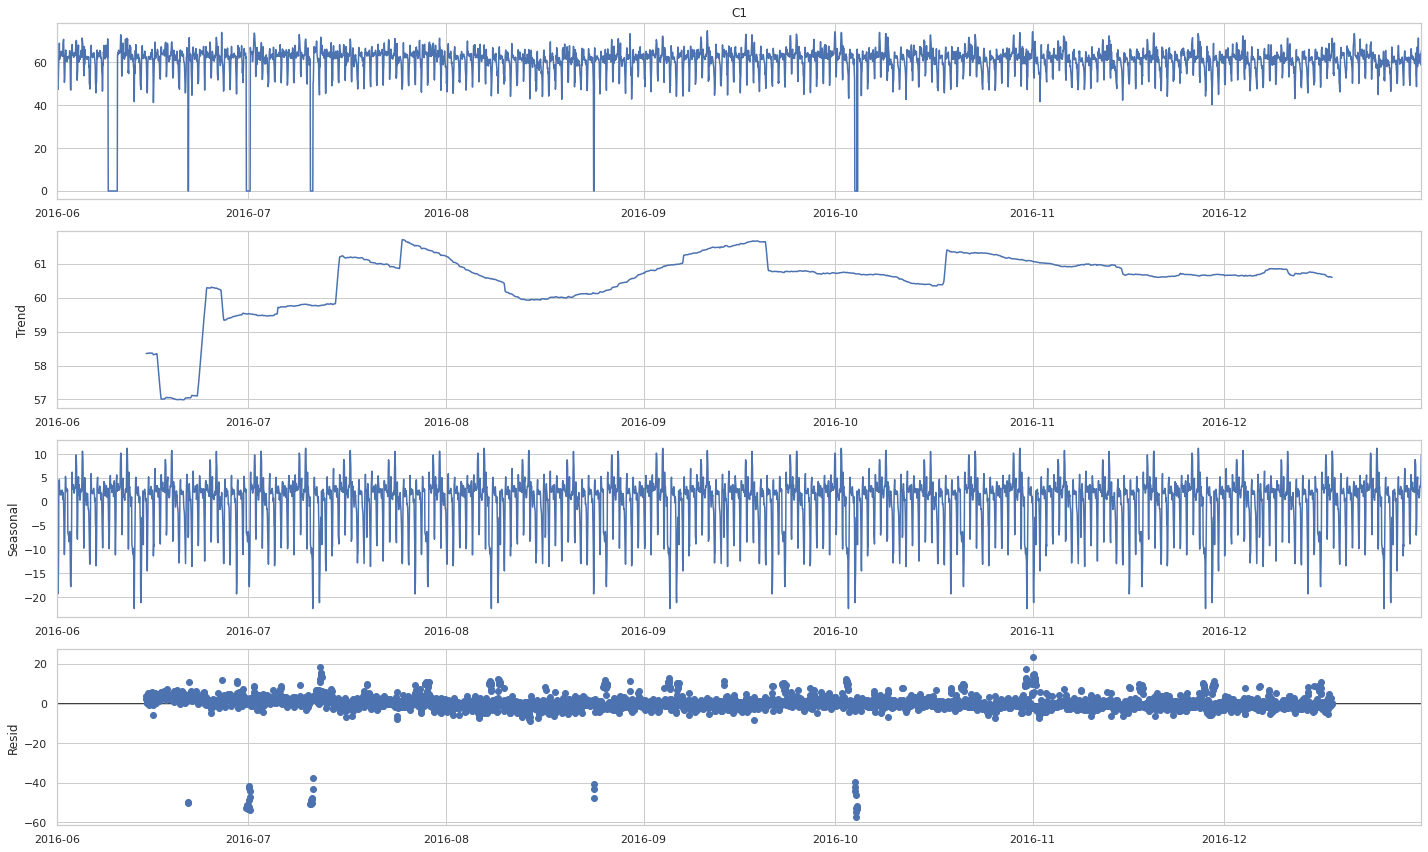

In [15]:
ts_seasonal_decompose(df[df.year==2016].C1, [24*7*4])

Ao considerar apenas o no de 2016 é mais perceptível a existência de padrões. Regra geral existe um tendencia crescente.

## Moving Average

<AxesSubplot:xlabel='date'>

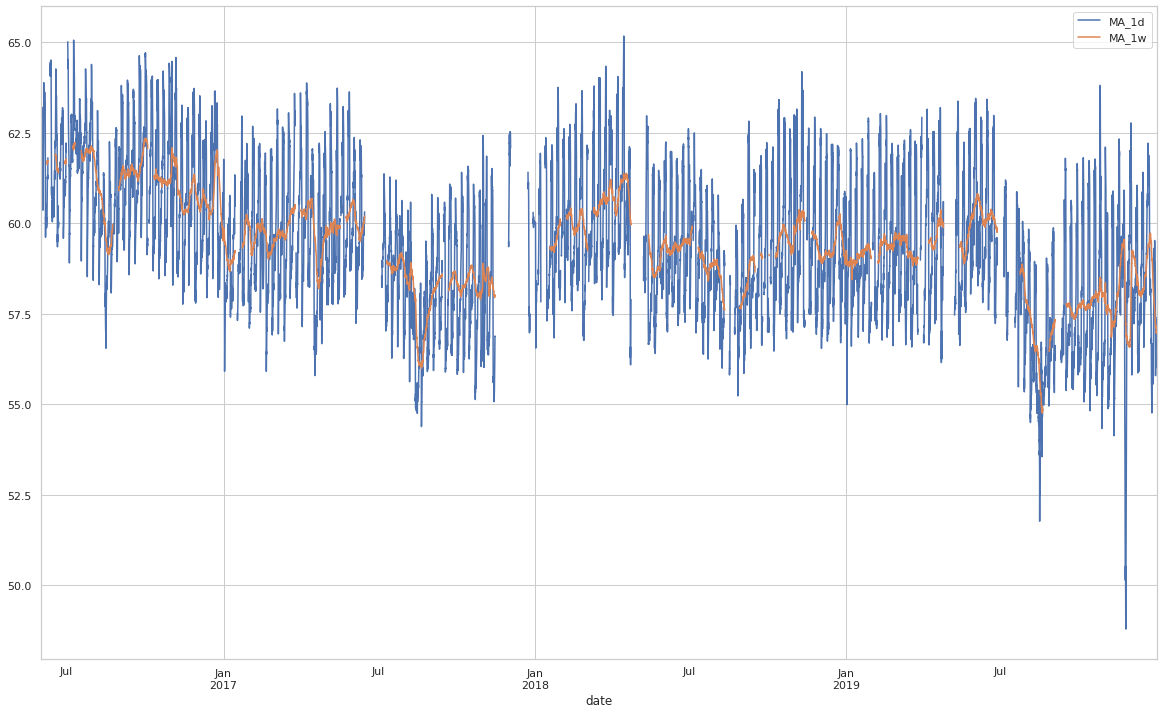

In [16]:
df['MA_1d'] = df['C1'].rolling(window=24).mean()
df['MA_1w'] = df['C1'].rolling(window=24*7).mean()

df[['MA_1d', 'MA_1w']].plot()

# Outlier Detection 

0 ou 1 se há ou não outlier

## Using Z-Score for excessive noise detection

In [17]:
def outlier_detection_using_z_score(df, t=1, sensor='C1'):
    # t - threshold - number of standard deviation
    mean = np.mean(df.iloc[:, 0])
    std = np.std(df.iloc[:, 0])
    
    # não fazemos abs((i-mean)/std) porque só nos interessa os que estão acima da média
    df['z_score'] = [(i-mean)/std for i in df.iloc[:, 0]]
    df['is_outlier'] = [1 if x>t else 0 for x in df.z_score.values ]
    
    df['out'] = df[sensor] * df['is_outlier']
    df['out'] = [None if x==0 else x for x in df.out.values]

    df = df.reset_index()
    
    return df
    
    
df_out = outlier_detection_using_z_score(df[['C1']])
df_out

,date,C1,z_score,is_outlier,out
0,2016-06-01 00:00:00,61.1,0.291701,0,NaN
1,2016-06-01 01:00:00,57.2,-0.401050,0,NaN
2,2016-06-01 02:00:00,52.5,-1.235904,0,NaN
3,2016-06-01 03:00:00,50.6,-1.573398,0,NaN
4,2016-06-01 04:00:00,47.4,-2.141809,0,NaN
...,...,...,...,...,...
31411,2019-12-31 19:00:00,62.2,0.487092,0,NaN
31412,2019-12-31 20:00:00,59.4,-0.010268,0,NaN
31413,2019-12-31 21:00:00,59.2,-0.045793,0,NaN
31414,2019-12-31 22:00:00,57.0,-0.436576,0,NaN


In [18]:
print("Number of outliers detected: " + str(df_out['is_outlier'].sum()))

Number of outliers detected: 2971


In [19]:
def get_avg_number_outliers(df, sensors):
    
    l_c_out = []
    
    for sensor in sensors:
        c_out = outlier_detection_using_z_score(df[[sensor]], 1, sensor).set_index('date')[['is_outlier']]
        c_out = c_out.rename(columns={'is_outlier': sensor + '_is_outlier'})
        l_c_out.append(c_out)
        
    df_tot = pd.concat(l_c_out, axis=1)
    df_tot = df_tot.resample('1D').sum()
    df_tot['mean_is_outlier'] = df_tot.mean(axis = 1)
    
    return df_tot
    
outliers_avg = get_avg_number_outliers(df, sensors)[['mean_is_outlier']]
outliers_avg

,mean_is_outlier
date,
2016-06-01,4.4
2016-06-02,2.2
2016-06-03,2.8
2016-06-04,5.2
2016-06-05,2.8
...,...
2019-12-27,0.4
2019-12-28,1.6
2019-12-29,1.4


## Visualizing the excessive noise detected

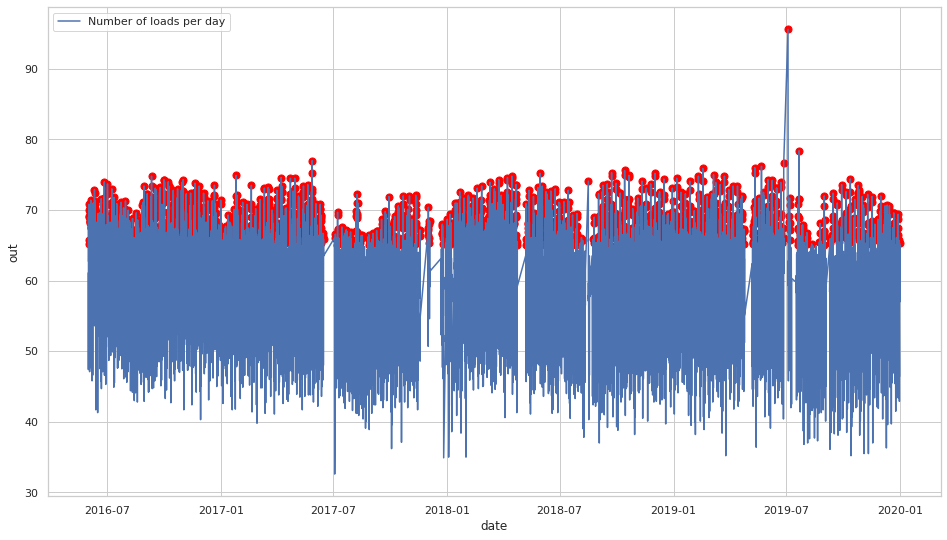

In [20]:
def plot_outliers(df):
    fig, ax = plt.subplots(figsize=fig_dim)

    sns.lineplot(data=df, x='date', y='C1', ax=ax, label="Number of loads per day")
    sns.regplot(data=df, x='date', y="out", fit_reg=False, 
                scatter_kws={"color":"red","alpha":1,"s":50}, ax=ax, label='Holidays')
    
plot_outliers(df_out)

In [21]:
df_out_m = df_out.set_index('date').resample('1M').sum()
df_out_m.head()

,C1,z_score,is_outlier,out
date,,,,
2016-06-30,41724.8,272.006747,118,7964.8
2016-07-31,45155.0,353.237963,157,10592.4
2016-08-31,44665.0,107.779102,83,5543.6
2016-09-30,44354.4,274.397025,115,7800.7
2016-10-31,45075.9,254.696389,126,8580.0


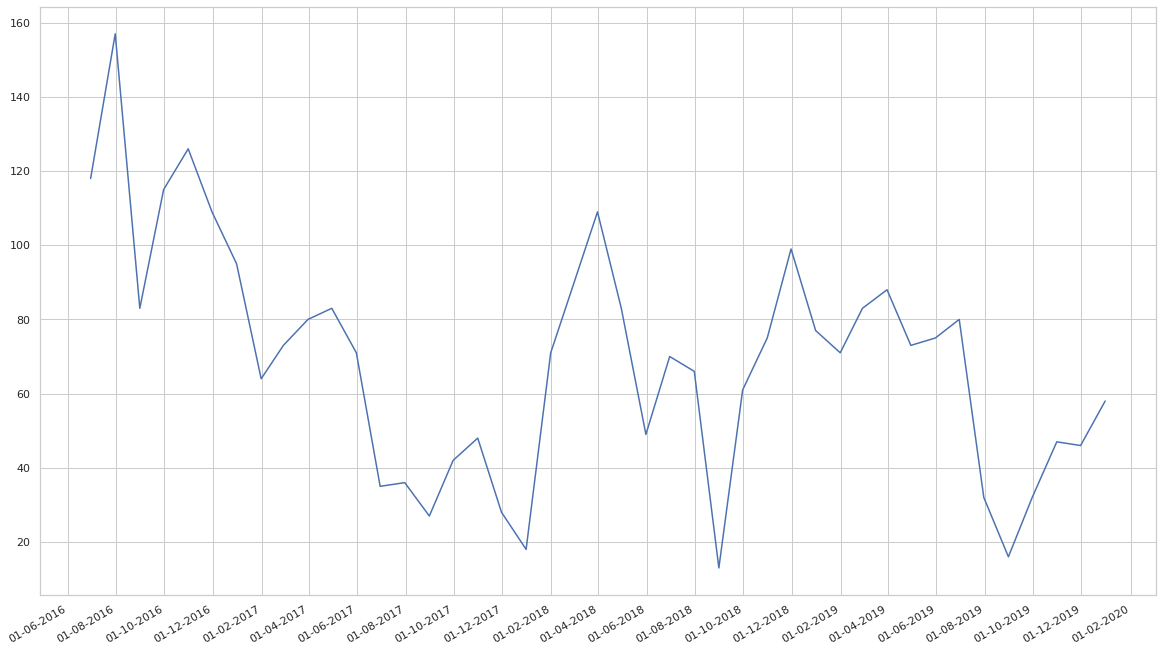

In [22]:
plt.figure()
plt.plot(df_out_m.index, df_out_m['is_outlier'])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

<AxesSubplot:xlabel='date'>

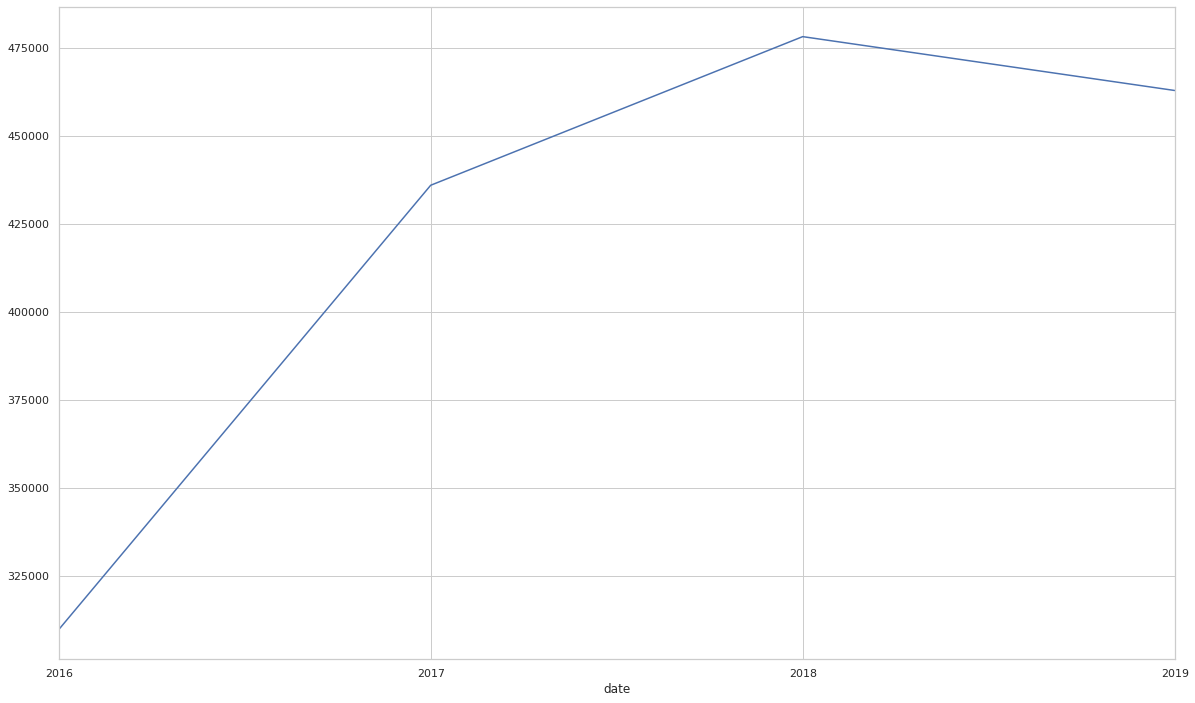

In [23]:
df_out_y = df_out.set_index('date').resample('1Y').sum()
df_out_y['C1'].plot()

# Predict future noise levels

O sarimax dá para ver o arima, o sarima e considerar vars exógenas (sendo que não as vamos usar para já)

## SARIMAX

In [24]:
outliers_avg

,mean_is_outlier
date,
2016-06-01,4.4
2016-06-02,2.2
2016-06-03,2.8
2016-06-04,5.2
2016-06-05,2.8
...,...
2019-12-27,0.4
2019-12-28,1.6
2019-12-29,1.4


In [41]:
def forecasting_with_sarimax(train, test, order, seasonal_order, lags):
    mod = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order)#, simple_differencing=True)
    res = mod.fit()
    predictions = res.forecast(steps=lags)
    rmse = math.sqrt(mean_squared_error(test, predictions))
    return res.bic, rmse, predictions

lags = 7*4
train = outliers_avg[:-lags]
test = outliers_avg[-lags:]


# Escolher o modelo com maior BIC
bic, rmse, predictions = forecasting_with_sarimax(train, test, (2,1,0), (1,1,0,12), lags)
print(bic, rmse)

5067.230645622369 1.1705847303547707


In [63]:
from itertools import product

# auxiliar method
# performs a correction on the seasonal parameters of sarimax, the 4th parameter is m
# m represents the period of the time series
def generate_sarima_parameters(combinations, m):
    combination_correction = []
    for t in combinations:
        lst = list(t)
        lst[3] = m
        combination_correction.append(tuple(lst))
    return combination_correction

# generates a list with all combinations of the seasonal parameters of sarimax
def generate_list_with_sarima_parameters(N, m):
    comb_sarima = list(product(range(0, N + 1), repeat = 4))
    combinations_sarima = list(dict.fromkeys(generate_sarima_parameters(comb_sarima, m)))
    #\  + generate_sarima_parameters(comb_sarima, 24*7)
    return combinations_sarima

# performs the sarimax method and creates a dataframe with the results
# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
def run_sarimax(train, test, lags, N, m):

    combinations_arima = list(product(range(0, N + 1), repeat = 3))
    combinations_sarima = generate_list_with_sarima_parameters(N, m)

    combinations_arima = combinations_arima
    combinations_sarima = combinations_sarima

    df_results = pd.DataFrame(columns=['bic', 'rmse', 'arima', 'sarima'])
    
    print("Combinations: " + str(len(combinations_arima)*len(combinations_sarima)))
    
    i=0

    for c_arima in combinations_arima:
        print(i)
        for c_sarima in combinations_sarima:
            bic, rmse, predictions = forecasting_with_sarimax(train, test, c_arima, c_sarima, lags)
            df_results = df_results.append({'bic':bic, 'rmse': rmse, 'arima':c_arima, 'sarima':c_sarima},\
                                           ignore_index=True)
            i += 1

    return df_results

results_sarimax = run_sarimax(train, test, lags, 1, 21) # com 2 demora muito tempo...
results_sarimax.head()

Combinations: 64
0
8
16
24
32
40
48
56


,bic,rmse,arima,sarima
0,6104.777286,1.530639,"(0, 0, 0)","(0, 0, 0, 21)"
1,5565.772355,1.052024,"(0, 0, 0)","(0, 0, 1, 21)"
2,5129.787683,1.480347,"(0, 0, 0)","(0, 1, 0, 21)"
3,4718.576933,0.715839,"(0, 0, 0)","(0, 1, 1, 21)"
4,5082.395466,0.961484,"(0, 0, 0)","(1, 0, 0, 21)"
5,4820.848443,0.700482,"(0, 0, 0)","(1, 0, 1, 21)"
6,4923.935776,1.140523,"(0, 0, 0)","(1, 1, 0, 21)"
7,4668.606849,0.830532,"(0, 0, 0)","(1, 1, 1, 21)"
8,5276.670785,1.531937,"(0, 0, 1)","(0, 0, 0, 21)"
9,4967.592648,1.089784,"(0, 0, 1)","(0, 0, 1, 21)"


In [64]:
# best model - using rmse as a metric
results_sarimax.sort_values(by='rmse').head(1)

,bic,rmse,arima,sarima
5,4820.848443,0.700482,"(0, 0, 0)","(1, 0, 1, 21)"


In [65]:
# best model - using bic as a metric
results_sarimax.sort_values(by='bic').head(1)

,bic,rmse,arima,sarima
59,4034.709123,0.823919,"(1, 1, 1)","(0, 1, 1, 21)"


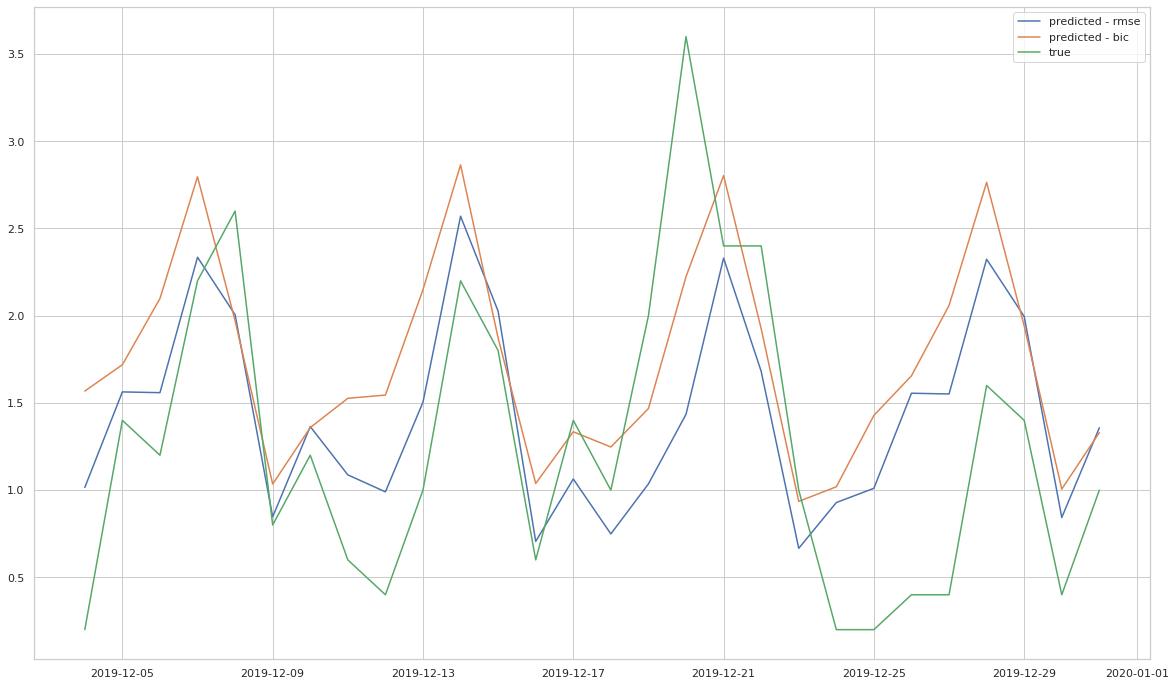

In [66]:
# comparasion on the obtained results

bic, rmse, predictions = forecasting_with_sarimax(train, test, (0, 0, 0), (1, 0, 1, 21), lags)
bic2, rmse2, predictions2 = forecasting_with_sarimax(train, test, (1, 1, 1), (0, 1, 1, 21), lags)

plt.plot(predictions, label='predicted - rmse')
plt.plot(predictions2, label='predicted - bic')
plt.plot(test, label='true')
plt.legend()

## CNN

# Medidas de combate ao barulho

Como é que o nosso modelo poderia ser usado?
Ao prever a existência de picos de ruído poderiam-se realizar patrulhas policiais nos dias em que se verificam picos (ou um nº maior de picos)

Como é que o nosso modelo poderia ser usado?
Ao prever a existência de picos de ruído poderiam-se realizar patrulhas policiais nos dias em que se verificam picos (ou um nº maior de picos)

- Add police patrols (if noise is expected)
- Obligate new commercial buildings to be constructed with materials that insulate noise. If this is not possible, limit building maximum capacity. 
- Plant trees (ajudam a eliminar níveis de ruído) (https://www.conserve-energy-future.com/can-trees-reduce-noise-pollution.php)
- Notify Authorities about Disobedience of Noise Rules
- reduzir o números de veículos em circulação na zona
- Prohibit cars from honking in certain areas (schools, universities, hospitals) 
- Limit excessive noise in public spaces

# Conclusions

## Scalability and Impact

## Future Work

# References